### Filtering by geographical criteria

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib.pyplot import cm
#from geojson import Feature, FeatureCollection#, Point
import json
import geojson
from shapely.geometry import Point, Polygon, LineString, MultiPoint, mapping, shape, asShape
#import shapely
import geopandas as gpd
#import geojsonio
from copy import deepcopy
import folium


I've exported __[El Retiro park shape](https://www.openstreetmap.org/way/4088755)__ in **GeoJSON** format from _OpenStreetMap_ by using the tool __[Overpass_turbo](http://overpass-turbo.eu/)__.
```c
// Retrieving El Retiro park from OSM
[out:json][timeout:25];
(
  // Query for El Retiro, whose way id is 4088755
  way(4088755);
);
// Print results
out body;
>;
// Returns geometry information of elements, but ignores the tags of the inner nodes
out skel qt;
```
![Retiro Park in OSM](img/osm-retiro-small.jpg)

In [4]:
#Let's start using GeoPandas. This is a very simple GeoDataFrame whose main geometry is the POLYGON with only one item: El Retiro
full_retiro=gpd.read_file('data/retiro.json')
full_retiro

id          @id  access             alt_name barrier leisure  \
0  way/4088755  way/4088755  public  Parque de El Retiro   fence    park   

                name         name:en            name:es           name:it  \
0  Parque del Retiro  El Retiro Park  Parque del Retiro  Parco del Retiro   

       name:pl      name:ru                             opening_hours   place  \
0  Park Retiro  Буэн-Ретиро  Oct-Mar 06:00-22:00; Apr-Sep 06:00-24:00  suburb   

  source:opening_hours  wikidata                       wikipedia  \
0               survey  Q1131807  es:Parque del Retiro de Madrid   

                                            geometry  
0  POLYGON ((-3.6858982 40.4087709, -3.681906 40....

In [5]:
#GeoPandas implements most of the Shapely functions to deal with geometries
#Accuracy of GPS is not perfect. In order to prevent misclassified points among the rides surrounding the park, actually not
#inside, we'll consider a narrower perimeter by leaving a buffer of around 25 meters to the park border.
narrow_retiro=full_retiro.buffer(-0.0003)
narrow_retiro

0    POLYGON ((-3.688492065704879 40.41705146092648...
dtype: object

In [6]:
#Back to dict format by using the Shapely function "mapping" then dumping to GeoJSON
#Let's take a look and make some manual adjustments on geojson.io

#json.dumps(mapping(full_retiro))
json.dumps(mapping(narrow_retiro))

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-3.6884920657048785, 40.41705146092648], [-3.6883700816277276, 40.418165753370175], [-3.6883694284294943, 40.41817240414757], [-3.6882921834511726, 40.41906048150703], [-3.6882592113406454, 40.41907157635415], [-3.6881498113406455, 40.41911637635415], [-3.688115965461321, 40.41913278445701], [-3.687928465461321, 40.419238684457014], [-3.687906771591823, 40.41925218696872], [-3.687886305459, 40.41926748661589], [-3.6878672155427803, 40.41928447240097], [-3.6878444987612995, 40.41930648866623], [-3.6877890987612996, 40.41936018866623], [-3.687764296635444, 40.41938737282856], [-3.6876970966354436, 40.41947077282856], [-3.6876726215751394, 40.419506044036986], [-3.6876176215751397, 40.41959884403698], [-3.6876034144998266, 40.41962586110055], [-3.6875920263742485, 40.41965418199934], [-3.687560568184379, 40.419745598118496], [-3.686291441964994, 40

Some manual adjustments were made using the embedded editor on __[geojson.io](http://geojson.io)__ and saved as **_narrow_\__retiro.json_**

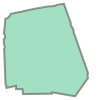

In [7]:
#Now we could reload our perimeter.
#In this case we won't keep it as a GeoDataFrame: we pass through GeoPandas to extract the POLYGON from the geometry GeoSeries
#in Shapely format.
retiro=gpd.read_file('data/narrow_retiro.json').geometry[0]
retiro

In [8]:
type(retiro)

shapely.geometry.polygon.Polygon

In [9]:
full_retiro.crs

{'init': 'epsg:4326'}

In [10]:
borde=full_retiro.difference(gpd.GeoSeries(retiro, crs={'init': 'epsg:4326'}))

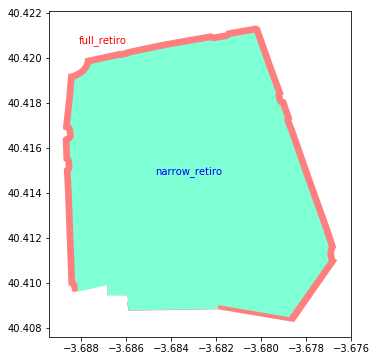

In [11]:
#Our Retiro perimeters
#Using a pure WGS 84 projection, that's why it looks "wider than on the typical maps", where Mercator projection is used.
ax=full_retiro.plot(figsize=(6,6), color='red', alpha=.5)
gpd.GeoSeries(retiro, crs={'init': 'epsg:4326'}).plot(ax=ax, color='aquamarine')
ax.text(0.1, 0.9, 'full_retiro', transform=ax.transAxes, color='red')
ax.text(0.35, 0.5, 'narrow_retiro', transform=ax.transAxes, color='blue')
_=plt.plot()
#borde.plot(ax=ax, color='black', alpha=.1)

#inner_retiro.plot(ax=ax, color='yellow', alpha=1)

**Projection on OpenStreetMaps**

![Retiro perimeters comparison](img/retiro_perimeters.png)

***
**<span style="color:red">Este filtrado de los trayectos sin GPS podría dejarlo en el notebook anterior, la verdad.</span>**

**<span style="color:red">fin</span>**
***

#### Listado de estaciones de BiciMAD
Con el objetivo de completar los track GPS y, posteriormente, crear features interesantes, se necesita el listado detallado de estaciones de BiciMAD repartidas por la ciudad: **172** en agosto de 2018.

In [12]:
#Leo y tomo la primera línea del json (estado de las estaciones la primera horas del mes), no necesito más
stations=next(pd.read_json('data/Bicimad_Estacions_201808.json', lines=True, chunksize=1))['stations']

In [13]:
stations=pd.DataFrame(stations[0])
stations

activate                             address  dock_bikes  free_bases  \
0           1                 Puerta del Sol nº 1          11          11   
1           1                 Puerta del Sol nº 1          10          14   
2           1              Calle Miguel Moya nº 1           1          23   
3           1       Plaza del Conde Suchil nº 2-4           8          10   
4           1         Calle Manuela Malasaña nº 5           0          23   
5           1             Calle Fuencarral nº 108           5          21   
6           1               Calle Hortaleza nº 63           2          22   
7           1               Calle Hortaleza nº 75           5          16   
8           1       Plaza de Alonso Martínez nº 5           3          21   
9           1            Plaza de San Miguel nº 9           6          18   
10          1  Calle Marqués de la Ensenada nº 16           3          21   
11          1              Calle San Andrés nº 18           5          19   
12          1            Calle San Bernardo nº 85           7          15   
13          1             Calle Conde Duque nº 22           8          15   
14          1        Calle Ventura Rodríguez nº 2           1          23   
15          1      Calle San Vicente Ferrer nº 64           6          14   
16          1            Calle San Bernardo nº 22           8          13   
17          1     Plaza de Carlos Cambronero nº 2           2          22   
18          1               Plaza de Pedro Zerolo           1          21   
19          1                     Calle Prim nº 2           2          21   
20          1                  Calle Alcalá nº 49           0          27   
21          1                 Calle Montera nº 48           0          10   
22          1                 Calle Montera nº 47           0           0   
23          1              Calle Jacometrezo nº 3           1          21   
24          1         Plaza de Santo Domingo nº 1           1          23   
25          1               Calle Carlos III nº 1           1          22   
26          1              Plaza de Celenque nº 1           3          21   
27          1              Plaza de Celenque nº 1           1          23   
28          1              Plaza de las Salesas 7          11          10   
29          1                    Calle Jesús nº 1           9          15   
..        ...                                 ...         ...         ...   
142         1        Paseo de la Castellana nº 67           0          23   
143         1   Calle José Gutiérrez Abascal nº 2           8          16   
144         1              Calle Velázquez nº 130          14          10   
145         1        Paseo de la Castellana nº 43           0          12   
146         1        Paseo de la Castellana nº 42           0          22   
147         1           Calle Diego de León nº 52           5          18   
148         1              Calle Juan Bravo nº 50           7          17   
149         1         Calle Ortega y Gasset nº 87          19           5   
150         1          Calle María Francisca nº 1          15           0   
151         1       Avenida del Doctor Arce nº 45          17           6   
152         1                Calle Serrano nº 210           6          17   
153         1            Paseo de la Habana nº 42          10          13   
154         1       Paseo de la Castellana nº 124           1          23   
155         1                  Calle Orense nº 12          11          13   
156         1    Avenida del General Perón nº 1-4          17           6   
157         1     Avenida del General Perón nº 36           1          23   
158         1                  Calle Orense nº 36           9          14   
159         1       Calle del General Yagüe nº 57          22           0   
160         1    Calle Sor Ángela de la Cruz nº 2           2          22   
161         1       Paseo de la Castellana nº 164          17           7   
1

In [14]:
#Latitude and longitude must be numeric in order to do geometric manipulations
stations[['latitude','longitude']]=stations[['latitude','longitude']].astype('float')

In [15]:
stations.dtypes

activate                int64
address                object
dock_bikes              int64
free_bases              int64
id                      int64
latitude              float64
light                   int64
longitude             float64
name                   object
no_available            int64
number                 object
reservations_count      int64
total_bases             int64
dtype: object

In [16]:
#No hacen falta todas las columnas
stations.drop(stations.columns.difference(['address','id','latitude','longitude','name','number']), axis=1, inplace=True)

In [17]:
stations['address']=stations['address'].str.replace('nº ','').str.upper()
stations

address   id   latitude  longitude  \
0                   PUERTA DEL SOL 1    1  40.416896  -3.702425   
1                   PUERTA DEL SOL 1    2  40.417001  -3.702421   
2                CALLE MIGUEL MOYA 1    3  40.420589  -3.705842   
3         PLAZA DEL CONDE SUCHIL 2-4    4  40.430294  -3.706917   
4           CALLE MANUELA MALASAÑA 5    5  40.428552  -3.702587   
5               CALLE FUENCARRAL 108    6  40.428528  -3.702060   
6                 CALLE HORTALEZA 63    7  40.424148  -3.698447   
7                 CALLE HORTALEZA 75    8  40.425191  -3.697771   
8         PLAZA DE ALONSO MARTÍNEZ 5    9  40.427868  -3.695440   
9              PLAZA DE SAN MIGUEL 9   10  40.415606  -3.709508   
10   CALLE MARQUÉS DE LA ENSENADA 16   11  40.425086  -3.691881   
11               CALLE SAN ANDRÉS 18   12  40.426948  -3.703592   
12             CALLE SAN BERNARDO 85   13  40.428425  -3.706193   
13              CALLE CONDE DUQUE 22   14  40.427326  -3.710442   
14         CALLE VENTURA RODRÍGUEZ 2   15  40.426096  -3.713479   
15       CALLE SAN VICENTE FERRER 64   16  40.426165  -3.707376   
16             CALLE SAN BERNARDO 22   17  40.423072  -3.707507   
17      PLAZA DE CARLOS CAMBRONERO 2   18  40.423265  -3.703831   
18             PLAZA DE PEDRO ZEROLO   19  40.420777  -3.699650   
19                      CALLE PRIM 2   20  40.421862  -3.695498   
20                   CALLE ALCALÁ 49   21  40.419234  -3.695461   
21                  CALLE MONTERA 48   23  40.419787  -3.701481   
22                  CALLE MONTERA 47   24  40.419720  -3.701523   
23               CALLE JACOMETREZO 3   25  40.420078  -3.706538   
24          PLAZA DE SANTO DOMINGO 1   26  40.419743  -3.708073   
25                CALLE CARLOS III 1   27  40.418215  -3.710354   
26               PLAZA DE CELENQUE 1   28  40.417311  -3.706481   
27               PLAZA DE CELENQUE 1   29  40.417278  -3.706384   
28            PLAZA DE LAS SALESAS 7   30  40.423855  -3.694475   
29                     CALLE JESÚS 1   31  40.413280  -3.695618   
..                               ...  ...        ...        ...   
142        PASEO DE LA CASTELLANA 67  154  40.445741  -3.691793   
143   CALLE JOSÉ GUTIÉRREZ ABASCAL 2  159  40.439679  -3.690778   
144              CALLE VELÁZQUEZ 130  162  40.437944  -3.682862   
145        PASEO DE LA CASTELLANA 43  165  40.435514  -3.689237   
146        PASEO DE LA CASTELLANA 42  167  40.433409  -3.687915   
147           CALLE DIEGO DE LEÓN 52  166  40.434597  -3.678492   
148              CALLE JUAN BRAVO 50  170  40.432366  -3.675855   
149         CALLE ORTEGA Y GASSET 87  171  40.429887  -3.671282   
150          CALLE MARÍA FRANCISCA 1  155  40.444226  -3.678717   
151       AVENIDA DEL DOCTOR ARCE 45  148  40.448327  -3.679730   
152                CALLE SERRANO 210  144  40.451019  -3.681796   
153            PASEO DE LA HABANA 42  146  40.449861  -3.688169   
154       PASEO DE LA CASTELLANA 124  147  40.448892  -3.690560   
155                  CALLE ORENSE 12  145  40.448066  -3.695286   
156    AVENIDA DEL GENERAL PERÓN 1-4  142  40.452716  -3.699008   
157     AVENIDA DEL GENERAL PERÓN 36  143  40.452294  -3.692651   
158                  CALLE ORENSE 36  141  40.454846  -3.694622   
159       CALLE DEL GENERAL YAGÜE 57  139  40.457282  -3.700967   
160    CALLE SOR ÁNGELA DE LA CRUZ 2  140  40.459235  -3.691533   
161       PASEO DE LA CASTELLANA 164  137  40.459137  -3.689415   
162    AVENIDA DE ALBERTO ALCOCER 22  138  40.458532  -3.684715   
163            PASEO DE LA HABANA 63  173  40.454385  -3.683593   
164                 CALLE COLOMBIA 7  172  40.457247  -3.676344   
165            PASEO DE LA FLORIDA 8  132  40.422081  -3.721848   
166            PASEO DE LOS OLMOS 28  133  40.403408  -3.710811   
167          PASEO DE LA ESPERANZA 2  134  40.403599  -3.706452   
168      PASEO DE LAS DELICIAS 92-94  136  40.397262  -3.694503   
169           PASEO DE LA CHOPERA 14  135  40.391939  -3.697183   
170      

In [18]:
#Confirmamos que no hay ids repetidos en el listado de estaciones
stations['id'].duplicated(keep=False).any()

False

El track GPS del que dispone cada trayecto consta de todos los puntos intermedios pero, por alguna razón, **no incluye el origen y el destino** del mismo. No obstante podemos inferir esos dos puntos pues sí conocemos las estaciones de origen y destino.
De modo que vamos a completar el track con las coordenadas de las estaciones de origen _(primer punto, t=0)_ y destino _(último punto, t=travel_\__time)_, sirviéndonos de los datos importados anteriormente. 

Tener el track completo será interesante para crear algunas features (por ejemplo distancia líneal total entre puntos) o para hacer representaciones más precisas en el mapa.

In [19]:
#This function creates an improved version of the GPS track by adding the origin and destination points,
#based on the stations information.

def improve_track(ride, stations):
    station_orig = stations[stations['id'] == ride.idunplug_station].iloc[0]
    station_dest = stations[stations['id'] == ride.idplug_station].iloc[0]
    #Origin
    feature_orig={'geometry': {'type': 'Point', 'coordinates': [station_orig.longitude, station_orig.latitude]},
                  'type': 'Feature',
                  'properties': {'var': station_orig.address,
                                 'speed': 0,
                                 'secondsfromstart': 0}}
    #Destination
    feature_dest={'geometry': {'type': 'Point', 'coordinates': [station_dest.longitude, station_dest.latitude]},
                  'type': 'Feature',
                  'properties': {'var': station_dest.address,
                                 'speed': 0,
                                 'secondsfromstart': ride.travel_time}}
    #Object duplication so the original track is not lost
    improved_track = deepcopy(ride.track)
    improved_track['features'].insert(0,feature_dest)
    improved_track['features'].append(feature_orig)
    return improved_track

***
*** Prueba track enriquecido ***

***

In [20]:
#The dataframe containing the enhanced tracks is backed up in order to not repeat that heavy treatment in future runs
# /!\ Wall time: 52s
#%time rides.to_json('data/cleanFullTracksAugust.json', orient='records', date_format='iso', lines=True)

In [21]:
#Esta es la lectura de una versión limpia pero sólo con los trayectos CON track y además la versión enriquecida (full_track)
# /!\ Wall time: 1min 31s
rides=pd.read_json('data/good/cleanFullTracksAugust.json', lines=True, dtype={'zip_code':object}, convert_dates=['unplug_hourTime'])

In [40]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(rides.idunplug_station.value_counts().sort_index())

1      2748
2      1260
3      1531
4       914
5       963
6      1733
7       995
8      1202
9      2058
10     1282
11      680
12     1074
13     1637
14     1120
15      731
16      982
17     1204
18     1252
19     2563
20      939
21     1308
25     1273
26     1886
27     1188
28      305
29      516
30     1468
31     1924
32      516
33      960
34      737
35      895
36      988
38     2136
39      832
40      821
41     2495
42      790
43     2799
44     1583
45      781
46     2119
47     1433
48     1222
49     2482
50     1263
51     1200
52     1962
53     2194
54     1182
55     1420
56     1960
57     2473
58     2136
59     2314
60     1242
61      331
62     1720
63     1197
64     2848
65     1235
66     1073
67     1213
69      995
71     1250
72      796
73     1475
74     1788
75     1400
76     1193
77     1208
78     1145
79     1848
80     1317
81     1168
82     1948
83     2411
84     1589
85      733
86     1153
87      834
88      364
89     1063
90  

In [42]:
#JSON I/O process couldn't deal with the timezone. We localize our datetime on the Central European Time.
rides['unplug_hourTime']=pd.Series(pd.DatetimeIndex(rides['unplug_hourTime']).tz_localize('UTC').tz_convert('CET'))

In [43]:
#pandas-dev Issue #21892 doesn't allow to deal with categories as a dtype on read_json, so we make the conversion here
rides[['ageRange','idplug_station','idunplug_station','user_type']]=\
rides[['ageRange','idplug_station','idunplug_station','user_type']].astype('category')

In [44]:
#We check the right types were kept.
#Strings and dict as objets, time travel as a number, datetime on the right timezone and four categories with well-known values: 
rides.dtypes

_id                              object
ageRange                       category
full_track                       object
idplug_station                 category
idunplug_station               category
track                            object
travel_time                       int64
unplug_hourTime     datetime64[ns, CET]
user_day_code                    object
user_type                      category
zip_code                         object
dtype: object

In [45]:
rides.count()

_id                 224536
ageRange            224536
full_track          224536
idplug_station      224536
idunplug_station    224536
track               224536
travel_time         224536
unplug_hourTime     224536
user_day_code       224536
user_type           224536
zip_code            115959
dtype: int64

###### Tipos de usuario
**1**: Usuario anual (abonado)
**2**: Usuario ocasional
**3**: Trabajador de la empresa

In [46]:
rides['user_type'].value_counts()

1    202609
3     16186
2      5741
Name: user_type, dtype: int64

**<span style="color:red">Introducir aquí un plot al menos ilustrando las particularidades de los user_type=3</span>** (M-30 y demás)

***

Para nuestro análisis vamos a descartar los movimientos realizados por trabajadores de la empresa pues parecen tratarse de desplazamientos para reabastecer estaciones o por motivos de mantenimiento.

In [47]:
#We'll work only with rides by "real" users
rides = rides.query('user_type != 3')

In [48]:
rides['user_type'].value_counts()

1    202609
2      5741
3         0
Name: user_type, dtype: int64

In [49]:
rides.describe()

travel_time
count  208350.000000
mean      979.998435
std      1246.950072
min        23.000000
25%       461.000000
50%       681.000000
75%      1017.000000
max     21598.000000

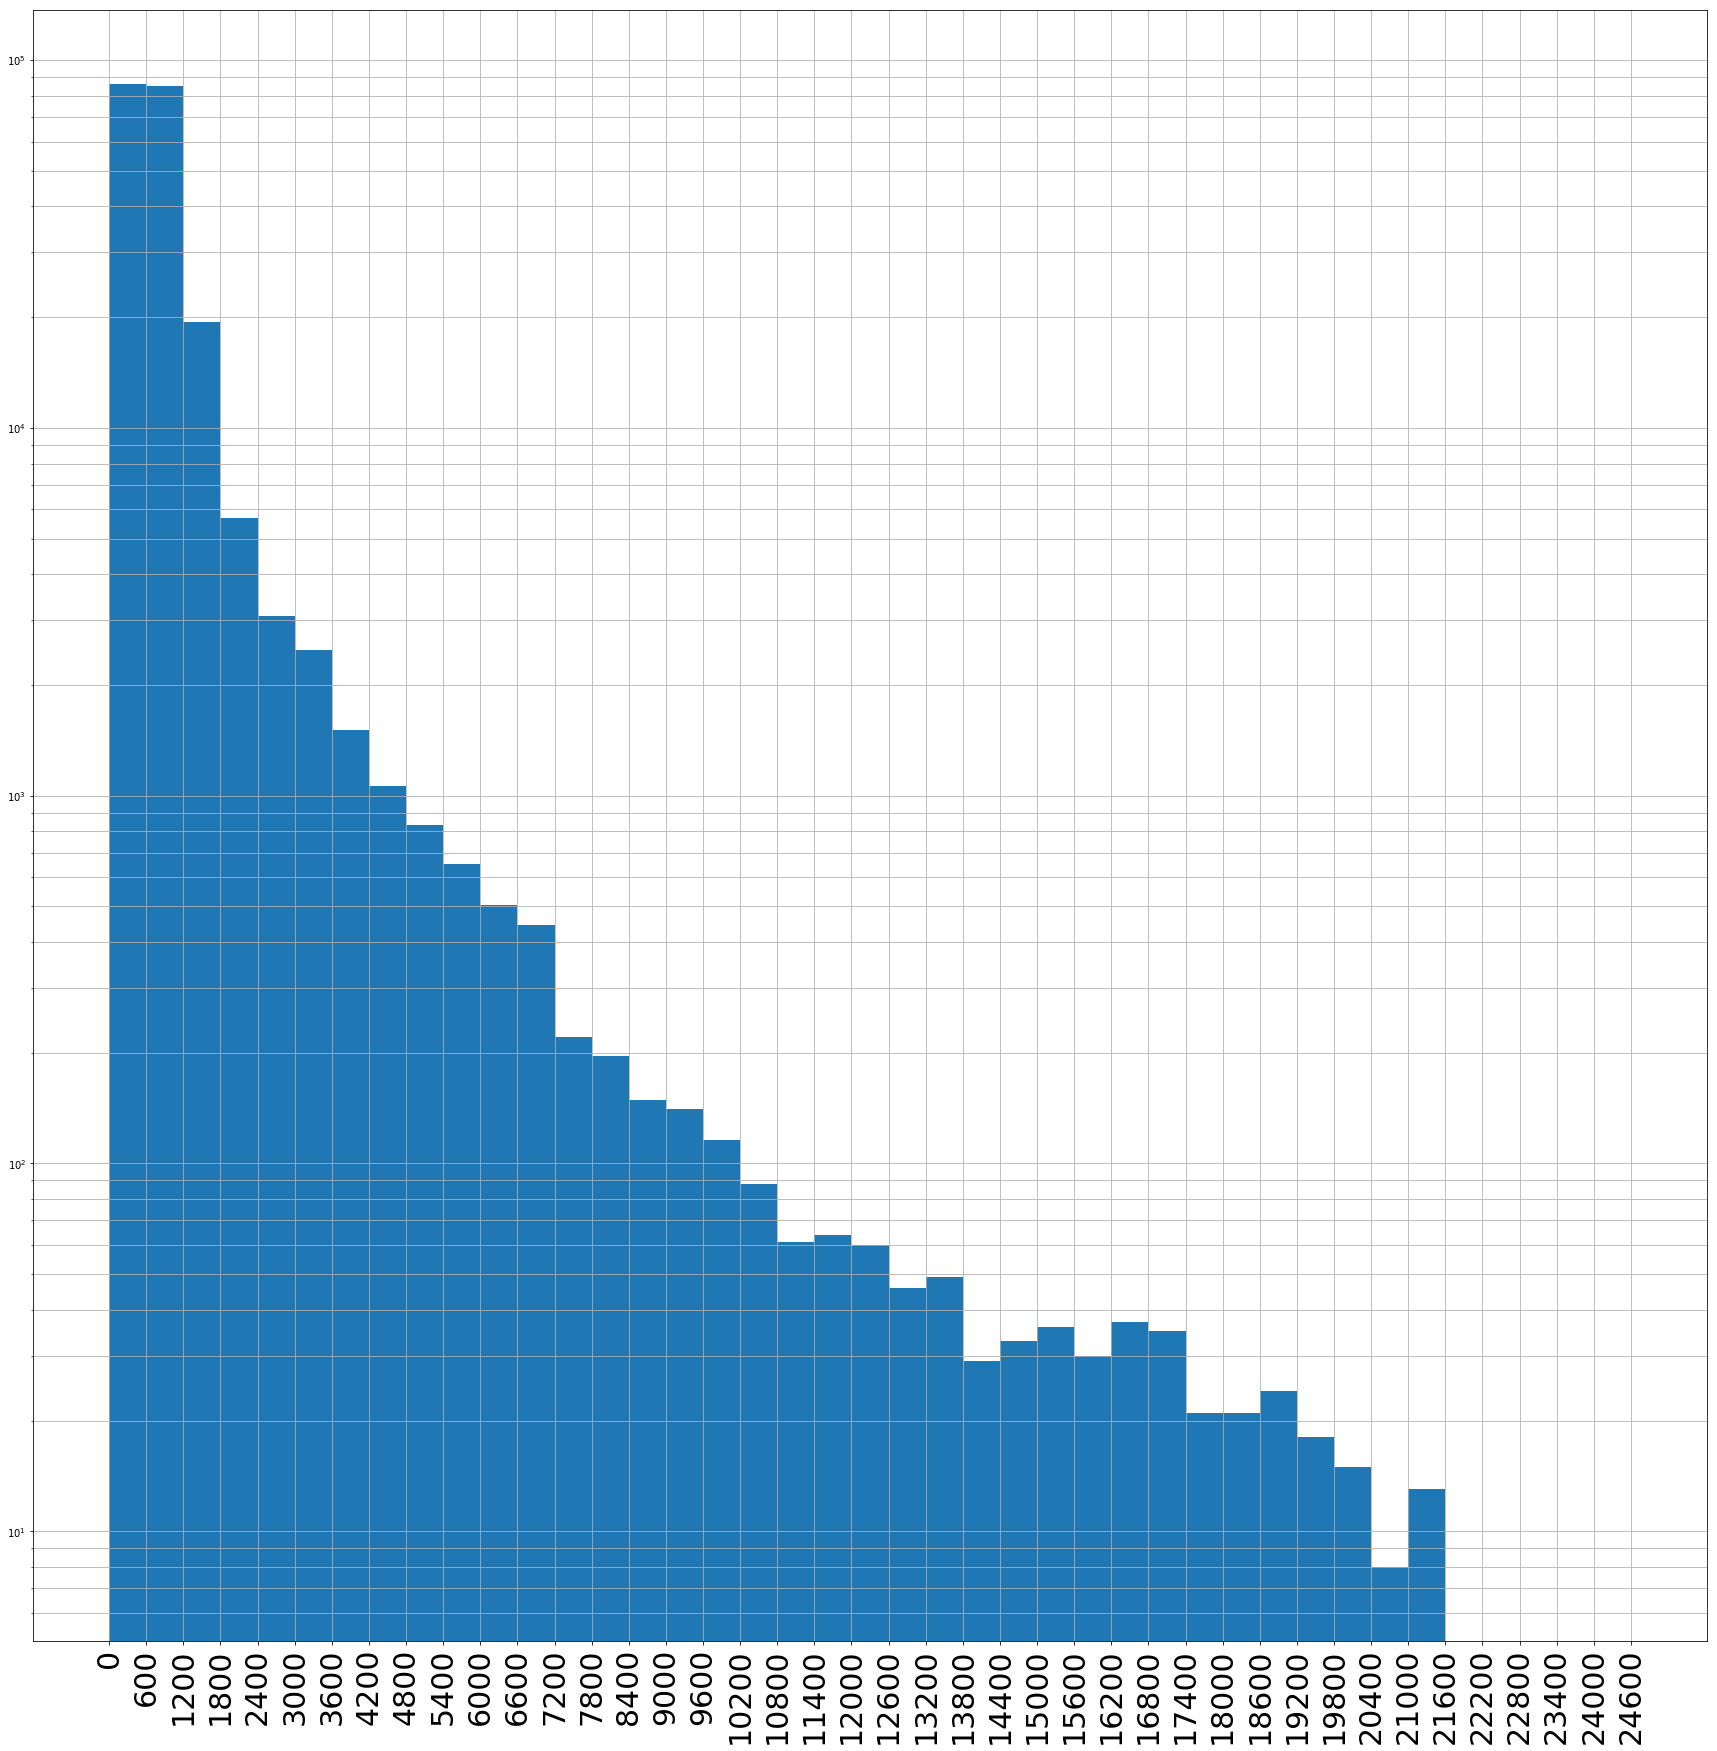

In [414]:
fig, ax = plt.subplots(figsize=(30,30))
rides['travel_time'].hist(ax=ax, bins=np.arange(0, 25000, 600))
ax.set_yscale('log')
ax.set_xticks(np.arange(0, 25000, 600))
ax.grid(which='minor')
ax.set_xticklabels(np.arange(0, 25000, 600), rotation=90, fontsize=30)
#ax.set_yticklabels(y_ticks, rotation=0, fontsize=8)
_ = plt.plot()

In [31]:
#Hemos exportado los datos para consultarlos rápidamente si hace falta y podemos prescindir de este objeto
del(tech_rides)

In [24]:
rides.count()

_id                 208350
ageRange            208350
full_track          208350
idplug_station      208350
idunplug_station    208350
track               208350
travel_time         208350
unplug_hourTime     208350
user_day_code       208350
user_type           208350
zip_code            114556
dtype: int64

#### Geographical outliers
Let's ensure all the rides stay inside the city. Same procedure to export the municipality of Madrid perimeter from OSM on GeoJSON format.

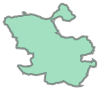

In [50]:
madrid=gpd.read_file('data/madrid.json').geometry[0]
madrid

In [51]:
madrid.wkt #So here it is... so tricky

'POLYGON ((-3.5311901 40.4200833, -3.5308782 40.4183949, -3.5305482 40.4165621, -3.5302303 40.4147088, -3.5304147 40.4147078, -3.5307286 40.4146422, -3.5309531 40.414563, -3.5313036 40.4144154, -3.5316854 40.4142916, -3.5322965 40.4141597, -3.5327887 40.4141076, -3.5333217 40.41411, -3.5339655 40.4141774, -3.5344149 40.4142421, -3.5351716 40.4144134, -3.5356265 40.4131503, -3.5357326 40.4131369, -3.535862 40.4130956, -3.5359677 40.4130405, -3.5360659 40.4129702, -3.536164 40.4128418, -3.536211 40.4127163, -3.5362286 40.4126117, -3.5362057 40.4125154, -3.536474 40.4125723, -3.53676 40.4125999, -3.5370384 40.4125969, -3.537309 40.4125551, -3.5374842 40.4125074, -3.5376659 40.4124237, -3.5377865 40.412354, -3.5378486 40.4122837, -3.537888 40.4121885, -3.537862 40.4118206, -3.5379001 40.4117363, -3.5379593 40.4116747, -3.5382799 40.4114284, -3.5383757 40.4114115, -3.5386738 40.4114384, -3.5390808 40.4115436, -3.5394973 40.4116295, -3.5395794 40.4116262, -3.5396553 40.4115945, -3.5397366 40

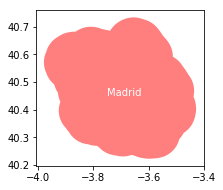

In [52]:
#### Madrid area roughly simplified: calculations will be lighter and we dont need much precison with this
#A buffer of around 8 kms is added, trying to roughly cover Madrid metropolitan area
madrid=madrid.buffer(0.09)
ax=gpd.GeoSeries(madrid).plot(figsize=(3,3), color='red', alpha=.5)
ax.text(0.42, 0.45, 'Madrid', transform=ax.transAxes, color='white')
_=plt.plot()

<img src="img/roughly_Madrid.png" width=500 align=left>

Definimos la función que determina si un trayecto no ha salido del municipio de Madrid. El criterio es verificar que **todos** los puntos del track GPS está dentro del municipio (***madrid***)

In [53]:
def is_in_Madrid(path=None):
    points=MultiPoint(gpd.GeoDataFrame.from_features(path['features']).geometry)
    return madrid.contains(points) #"contains" means ALL the MultiPoint remains inside the boundaries of Madrid

Let's create a fictional ride with **one point** so far away

In [ ]:
my_outlier={'type': 'FeatureCollection',
 'features': [{'geometry': {'type': 'Point',
    'coordinates': [-3.7088337, 40.4112744]},
   'type': 'Feature',
   'properties': {'var': 'PLAZA DE LA CEBADA 16 ',
    'speed': 0,
    'secondsfromstart': 228}},
  {'geometry': {'type': 'Point', 'coordinates': [-3.7078158, 40.4127144997]},
   'type': 'Feature',
   'properties': {'var': '28005,ES,Madrid,Madrid,CALLE SAN BRUNO 1,Madrid',
    'speed': 6.19,
    'secondsfromstart': 190}},
  {'geometry': {'type': 'Point', 'coordinates': [-3.7024255, 40.4168961]},
   'type': 'Feature',
   'properties': {'var': 'PUERTA DEL SOL 1',
    'speed': 0,
    'secondsfromstart': 0}}]}

In [ ]:
my_outlier['features'].insert(3, {'geometry': {'type': 'Point', 'coordinates': [-3.80158, 40.2427144997]},
   'type': 'Feature',
   'properties': {'var': 'FAR AWAY!',
    'speed': 1,
    'secondsfromstart': 100}})

In [ ]:
gpd.GeoSeries.plot

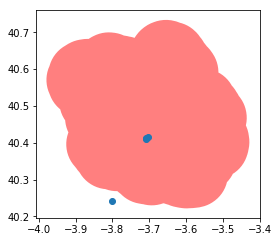

In [57]:
ax=gpd.GeoSeries(madrid).plot(figsize=(4,4), color='red', alpha=.5)
gpd.GeoDataFrame.from_features(my_outlier['features']).geometry.plot(ax=ax)
_=plt.show()

In [58]:
is_in_Madrid(my_outlier)

False

In [59]:
# /!\ Wall time: 4min 11s
in_Madrid = pd.Series(map(is_in_Madrid, rides['full_track']))

In [60]:
in_Madrid.value_counts()

True     208324
False        26
dtype: int64

In [61]:
outside_rides = rides[~in_Madrid.values]

In [62]:
#Rides getting outside Madrid!
rides[~in_Madrid.values]

_id ageRange  \
2723    5b6779132f384302541d7725        0   
3809    5b67791c2f384302541d7e26        0   
19110   5b68cac52f38433e00de10cd        4   
20598   5b6a1c1a2f38434d8862b32e        3   
25280   5b6a1c3d2f38434d8862cd7f        4   
52704   5b6f62812f38434d381dc697        4   
58282   5b6f62a62f38434d381de368        5   
58378   5b6f62a72f38434d381de3fa        0   
58540   5b7108142f38433dd87ae40b        0   
69227   5b7205482f3843505c6bd361        5   
79234   5b7356652f38434438ae74df        0   
80601   5b7356702f38434438ae7da6        4   
86601   5b74a7332f3843483412fdfd        0   
92892   5b75f9552f384313b84dcce0        0   
92916   5b75f9552f384313b84dcd11        5   
119161  5b7b40092f384345984d43d7        0   
141819  5b7f34842f384363e430d750        0   
145213  5b8086912f3843560c2940d0        0   
158720  5b81d6e62f384362d4ea0b62        0   
160495  5b81d6f32f384362d4ea147b        4   
160594  5b81d6f42f384362d4ea1528        4   
160745  5b81d6f52f384362d4ea1607        0   
171461  5b8329382f3843545085d027        4   
208002  5b89c0e22f384308b4b0917b        5   
216317  5b8b116c2f384363b0a2121d        3   
216352  5b8b116c2f384363b0a2124b        0   

                                               full_track idplug_station  \
2723    {'type': 'FeatureCollection', 'features': [{'g...            157   
3809    {'type': 'FeatureCollection', 'features': [{'g...             95   
19110   {'type': 'FeatureCollection', 'features': [{'g...             57   
20598   {'type': 'FeatureCollection', 'features': [{'g...             83   
25280   {'type': 'FeatureCollection', 'features': [{'g...             79   
52704   {'type': 'FeatureCollection', 'features': [{'g...             55   
58282   {'type': 'FeatureCollection', 'features': [{'g...            175   
58378   {'type': 'FeatureCollection', 'features': [{'g...             13   
58540   {'type': 'FeatureCollection', 'features': [{'g...            130   
69227   {'type': 'FeatureCollection', 'features': [{'g...            140   
79234   {'type': 'FeatureCollection', 'features': [{'g...             73   
80601   {'type': 'FeatureCollection', 'features': [{'g...            129   
86601   {'type': 'FeatureCollection', 'features': [{'g...            129   
92892   {'type': 'FeatureCollection', 'features': [{'g...            160   
92916   {'type': 'FeatureCollection', 'features': [{'g...             79   
119161  {'type': 'FeatureCollection', 'features': [{'g...            135   
141819  {'type': 'FeatureCollection', 'features': [{'g...            142   
145213  {'type': 'FeatureCollection', 'features': [{'g...             27   
158720  {'type': 'FeatureCollection', 'features': [{'g...              6   
160495  {'type': 'FeatureCollection', 'features': [{'g...             73   
160594  {'type': 'FeatureCollection', 'features': [{'g...             74   
160745  {'type': 'FeatureCollection', 'features': [{'g...             10   
171461  {'type': 'FeatureCollection', 'features': [{'g...             49   
208002  {'type': 'FeatureCollection', 'features': [{'g...             74   
216317  {'type': 'FeatureCollection', 'features': [{'g...              9   
216352  {'type': 'FeatureCollection', 'features': [{'g...             31   

       idunplug_station                                              track  \
2723                 63  {'type': 'FeatureCollection', 'features': [{'g...   
3809                 93  {'type': 'FeatureCollection', 'features': [{'g...   
19110                33  {'type': 'FeatureCollection', 'features': [{'g...   
20598                27  {'type': 'FeatureCollection', 'features': [{'g...   
25280               112  {'type': 'FeatureCollection', 'features': [{'g...   
52704               122  {'type': 'FeatureCollection', 'features': [{'g...   
58282                38  {'type': 'FeatureCollection', 'features': [{'g...   
58378                43  {'type': 'FeatureCollection', 'features': [{'g...   
58540                13  {'type': 'FeatureCollection', 'fe

In [63]:
outsideRides = gpd.GeoSeries()

In [64]:
for r in rides[~in_Madrid.values]['full_track'] :
    geoRide=LineString(gpd.GeoDataFrame.from_features(r['features'])['geometry'])
    outsideRides=outsideRides.append(gpd.GeoSeries(geoRide), ignore_index=True)

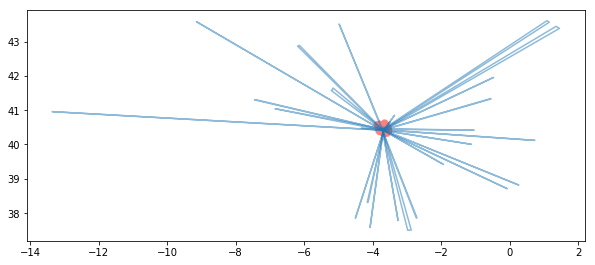

In [65]:
ax=gpd.GeoSeries(madrid).plot(figsize=(10,10), color='red', alpha=.5)
for r in rides[~in_Madrid.values]['full_track'] :
    gpd.GeoSeries(LineString(gpd.GeoDataFrame.from_features(r['features'])['geometry'])).plot(ax=ax, alpha=.5)

In [68]:
outliers = folium.Map([40.4155068, -3.6840015], zoom_start=7)

#color=iter(cm.rainbow(np.linspace(0,1,len(outsideRides))))

for p in outsideRides:
    r=folium.features.GeoJson(json.dumps(mapping(p)))
    r.style_function=lambda x: {'color':'blue', 'weight':1, 'opacity':.5}
    outliers.add_child(r)
outliers

In [69]:
rides[~in_Madrid.values].index

Int64Index([  2723,   3809,  19110,  20598,  25280,  52704,  58282,  58378,
             58540,  69227,  79234,  80601,  86601,  92892,  92916, 119161,
            141819, 145213, 158720, 160495, 160594, 160745, 171461, 208002,
            216317, 216352],
           dtype='int64')

In [70]:
rides.drop(rides[~in_Madrid.values].index, inplace=True).reset_index(drop=True, inplace=True)

In [71]:
len(rides)

208324

In [72]:
rides.dtypes

_id                              object
ageRange                       category
full_track                       object
idplug_station                 category
idunplug_station               category
track                            object
travel_time                       int64
unplug_hourTime     datetime64[ns, CET]
user_day_code                    object
user_type                      category
zip_code                         object
dtype: object

### Retiro tracks
Now let's pick the rides that got inside El Retiro, at least for a while.

Definimos la función que determina si un trayecto ha pasado o no por el Retiro. El criterio es verificar si **algún** punto del track GPS está dentro del perímetro del parque (***narrow_retiro***)

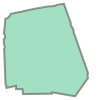

In [74]:
retiro

In [75]:
def intersectsRetiro(path=None):
    points=MultiPoint(gpd.GeoDataFrame.from_features(path['features']).geometry)
    return retiro.intersects(points)

In [77]:
# /!\ Wall time: 3min 52s
%time rides['in_Retiro']=pd.Series(map(intersectsRetiro, rides['full_track']))

Wall time: 3min 51s


In [79]:
#So around 10% of the rides passed through El Retiro park
print('Count:\n',rides['in_Retiro'].value_counts())
print('Proportion:\n',rides['in_Retiro'].value_counts(normalize=True))

Count:
 False    186963
True      21361
Name: in_Retiro, dtype: int64
Proportion:
 False    0.897463
True     0.102537
Name: in_Retiro, dtype: float64


KeyboardInterrupt: 

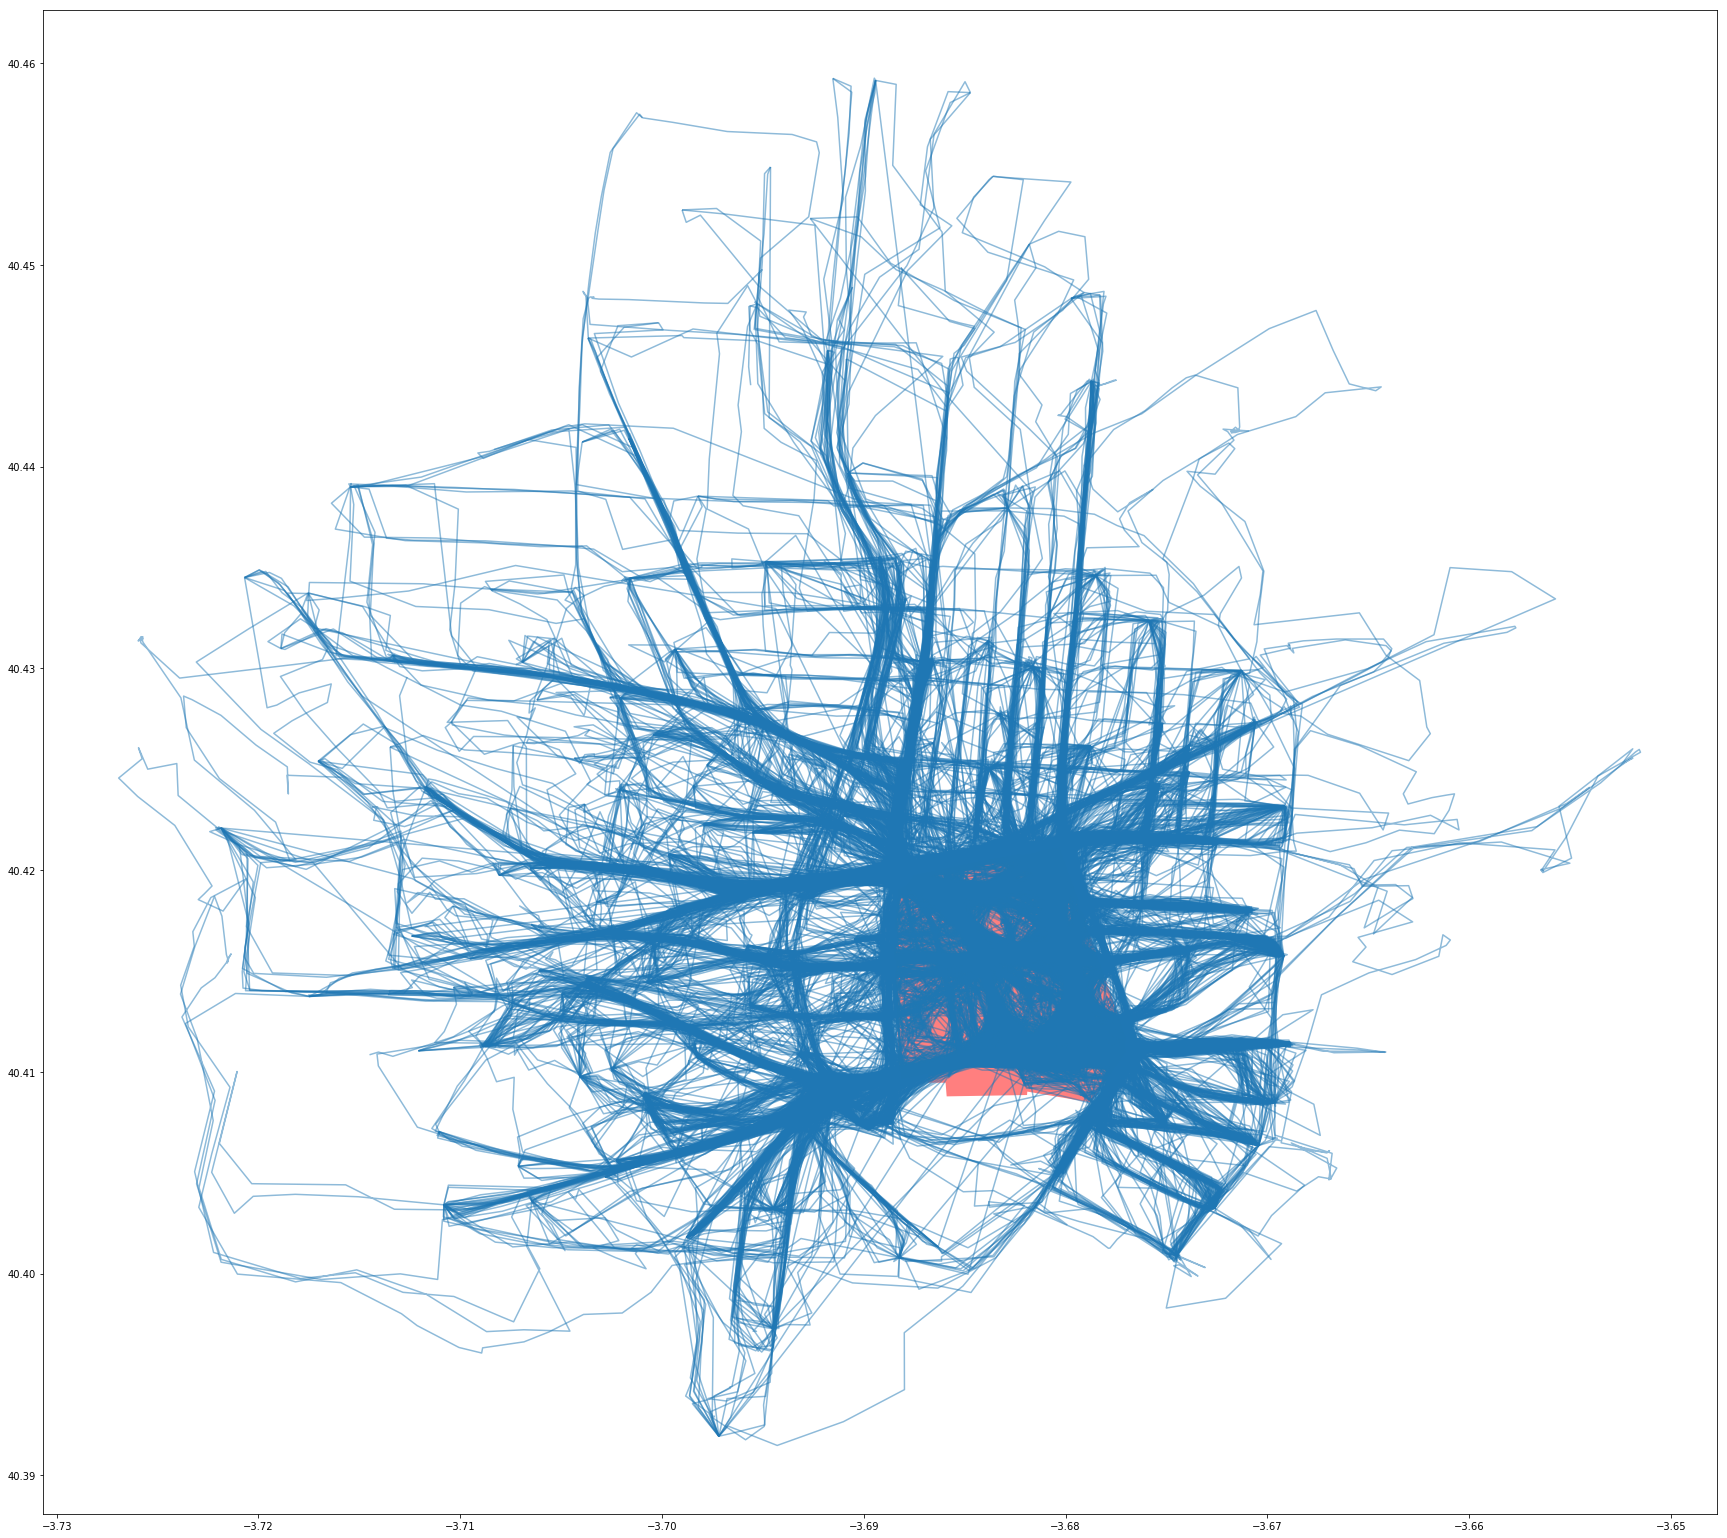

In [525]:
ax=gpd.GeoSeries(madrid).plot(figsize=(10,10), color='red', alpha=.5)
#for r in rides[~in_Madrid.values]['full_track'] :
    gpd.GeoSeries(LineString(gpd.GeoDataFrame.from_features(r['features'])['geometry'])).plot(ax=ax, alpha=.5)

### Mostrar basemap (tiles) con Cartopy ...

In [24]:
import cartopy.crs as ccrs

In [25]:
import cartopy.io.img_tiles as cimgt

In [109]:
gpd.GeoSeries(gpd.GeoSeries(retiro))

TypeError: __init__() got an unexpected keyword argument 'geometry'

### Visualizaciones interactivas

Una muestra de 1000 trayectos que **no** entraron al Retiro :

In [181]:
geo_str = json.dumps(json.load(open('data/narrow_retiro.json', 'r')))

mapa = folium.Map([40.4155068, -3.6840015], zoom_start=15)

mapa.add_child(folium.features.GeoJson(geo_str))
for p in rides[rides['in_Retiro']==False].sample(1000,random_state=98)['full_track']:
    r=folium.features.GeoJson(mapping(LineString(gpd.GeoDataFrame.from_features(p['features'])['geometry'])))
    r.style_function=lambda x: {'color':'red', 'weight':1, 'opacity':.3}
    mapa.add_child(r)
mapa

Una muestra de 100 trayectos que pasan por dentro del Retiro :

In [185]:
geo_str = json.dumps(json.load(open('data/narrow_retiro.json', 'r')))

mapa = folium.Map([40.4155068, -3.6840015], zoom_start=15)

mapa.add_child(folium.features.GeoJson(geo_str))
for p in rides[rides['in_Retiro']==True].sample(100,random_state=113)['full_track']:
    r=folium.features.GeoJson(mapping(LineString(gpd.GeoDataFrame.from_features(p['features'])['geometry'])))
    r.style_function=lambda x: {'color':'green', 'weight':2, 'opacity':.7}
    mapa.add_child(r)
mapa

In [47]:
#We'll work only with rides by "real" users
rides = rides.query('user_type != 3')

In [48]:
rides['user_type'].value_counts()

1    202609
2      5741
3         0
Name: user_type, dtype: int64

In [ ]:
rides['shapely_track'] = pd.Series(map(lambda r : LineString(gpd.GeoDataFrame.from_features(rides[rides['inRetiro']==False]['full_track'].iloc[0]['features'], crs='WGS84')['geometry']), rides['full_track']))

In [484]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208350 entries, 0 to 224535
Data columns (total 11 columns):
_id                 208350 non-null object
ageRange            208350 non-null category
full_track          208350 non-null object
idplug_station      208350 non-null category
idunplug_station    208350 non-null category
track               208350 non-null object
travel_time         208350 non-null int64
unplug_hourTime     208350 non-null datetime64[ns, CET]
user_day_code       208350 non-null object
user_type           208350 non-null category
zip_code            114556 non-null object
dtypes: category(4), datetime64[ns, CET](1), int64(1), object(5)
memory usage: 13.9+ MB


In [101]:
sample['inRetiro'].value_counts()

False    2718
True      282
Name: inRetiro, dtype: int64

In [120]:
pointsInRetiro=gpd.GeoSeries()
pointsNotInRetiro=gpd.GeoSeries()

In [236]:
for r in sample[sample['inRetiro']==True]['full_track'] :
    geoRide=gpd.GeoSeries(LineString(gpd.GeoDataFrame.from_features(r['features'], crs='WGS84')['geometry']))
    pointsInRetiro=pointsInRetiro.append(geoRide, ignore_index=True)

In [127]:
for r in sample[sample['inRetiro']==False]['full_track'] :
    geoRide=gpd.GeoSeries(gpd.GeoDataFrame.from_features(r['features'], crs='WGS84')['geometry'])
    pointsNotInRetiro=pointsNotInRetiro.append(geoRide, ignore_index=True)

In [ ]:
import folium

In [220]:
mapa = folium.Map([40.4155068, -3.6840015],
                  zoom_start=13, tiles=None)

#points = folium.features.GeoJson(json.dumps(mapping(pointsNotInRetiro)), smooth_factor=2,
 #                               style_function=lambda x: {'color' : 'red',
  #                                  'weight' : 0.8,
   #                                 'opacity': 0.6})

for p in pointsNotInRetiro:
    hey=folium.features.GeoJson(json.dumps(mapping(p)),
                                smooth_factor=2)
    hey.style_function=lambda x: {'color' : 'red',
                                  'weight' : 0.8,
                                  'opacity': 0.5}
    mapa.add_child(hey)

#mapa.save('data/folium2.html')
#mapa

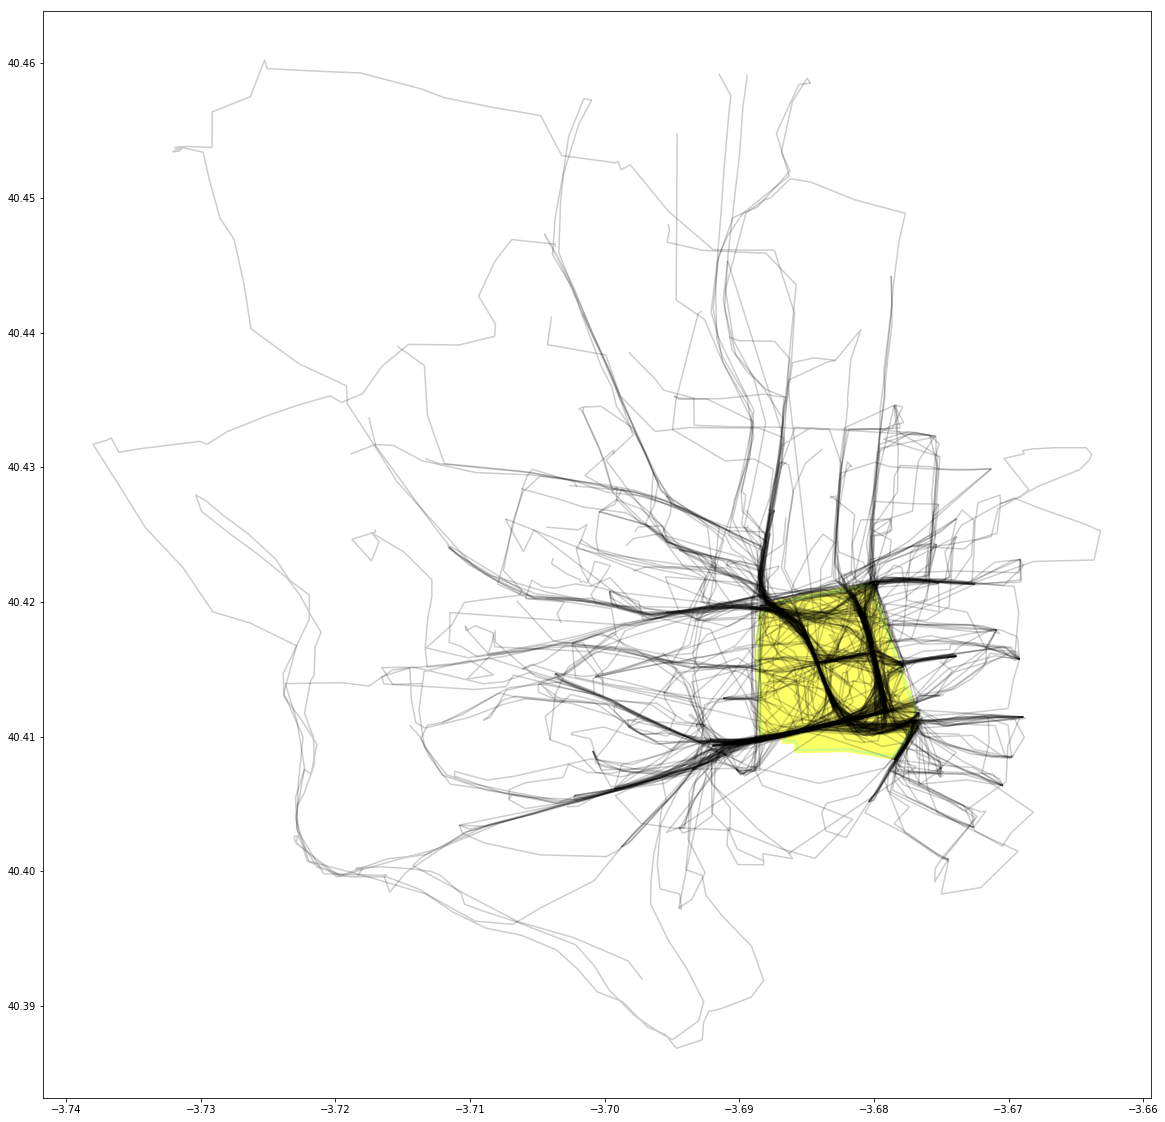

In [256]:
ax=raw_retiro.plot(figsize=[20,20], color='yellow', alpha=0.6)
#add_basemap(ax, zoom=10)
borde.plot(ax=ax, color='cyan', alpha=0.2)
pointsInRetiro.plot(ax=ax, color='black', alpha=0.1)
#pointsNotInRetiro.plot(ax=ax, color='red', alpha=0.1)

***
**<span style="color:red">Muestras para verificar la función de pertenencia con algunos plots</span>**


In [232]:
sample=rides[rides.user_type==3].reset_index()

In [450]:
sample=rides[rides.user_type==1].sample(3000,random_state=194).reset_index()

In [451]:
sample.head()

index                       _id ageRange  \
0  122356  5b7c91a72f38435ea06a2c7d        4   
1   14930  5b68caaf2f38433e00de0056        0   
2  177476  5b871dca2f384357e443921d        0   
3   66557  5b7205582f3843505c6be0c5        5   
4   69734  5b72056d2f3843505c6bf132        0   

                                          full_track idplug_station  \
0  {'type': 'FeatureCollection', 'features': [{'g...            132   
1  {'type': 'FeatureCollection', 'features': [{'g...            157   
2  {'type': 'FeatureCollection', 'features': [{'g...             91   
3  {'type': 'FeatureCollection', 'features': [{'g...             44   
4  {'type': 'FeatureCollection', 'features': [{'g...             26   

  idunplug_station  travel_time           unplug_hourTime  \
0               38          440 2018-08-17 19:00:00+02:00   
1               96         1018 2018-08-02 15:00:00+02:00   
2               43         1175 2018-08-25 01:00:00+02:00   
3              161          965 2018-08-09 14:00:00+02:00   
4              116          647 2018-08-09 20:00:00+02:00   

                                       user_day_code user_type zip_code  
0  da6bdf731e8b21c5b8ddedb1da2d1b07cdcce39a021e77...         1    28008  
1  9ebe17f1dc21db35c4a4faab8da06013a7da8c985b70b9...         1     None  
2  1c76d154d18aeb3ee3e7a76ee2f196da4f9c69554cb24d...         1     None  
3  269f9f99a1d2a53097e2cca02d18dbc19f060b5e98c505...         1    28012  
4  82efb05a418841851d9854dd81df0a77b9ef1b5842ab99...         1     None

In [458]:
sample['inRetiro']=pd.Series(map(intersectsRetiro, sample['full_track']))

In [447]:
sample.dtypes

NameError: name 'sample' is not defined

In [446]:
sample['inRetiro'].value_counts()

NameError: name 'sample' is not defined

In [461]:
pointsInRetiro=gpd.GeoSeries()
pointsNotInRetiro=gpd.GeoSeries()

In [462]:
for r in sample[sample['inRetiro']==True]['full_track'] :
    geoRide=gpd.GeoSeries(LineString(gpd.GeoDataFrame.from_features(r['features'], crs='WGS84')['geometry']))
    pointsInRetiro=pointsInRetiro.append(geoRide, ignore_index=True)

In [127]:
for r in sample[sample['inRetiro']==False]['full_track'] :
    geoRide=gpd.GeoSeries(gpd.GeoDataFrame.from_features(r['features'], crs='WGS84')['geometry'])
    pointsNotInRetiro=pointsNotInRetiro.append(geoRide, ignore_index=True)

In [321]:
import folium

<module 'folium' from 'C:\\Users\\vical\\Anaconda3\\lib\\site-packages\\folium\\__init__.py'>

In [220]:
mapa = folium.Map([40.4155068, -3.6840015],
                  zoom_start=13, tiles=None)

#points = folium.features.GeoJson(json.dumps(mapping(pointsNotInRetiro)), smooth_factor=2,
 #                               style_function=lambda x: {'color' : 'red',
  #                                  'weight' : 0.8,
   #                                 'opacity': 0.6})

for p in pointsNotInRetiro:
    hey=folium.features.GeoJson(json.dumps(mapping(p)),
                                smooth_factor=2)
    hey.style_function=lambda x: {'color' : 'red',
                                  'weight' : 0.8,
                                  'opacity': 0.5}
    mapa.add_child(hey)

#mapa.save('data/folium2.html')
#mapa

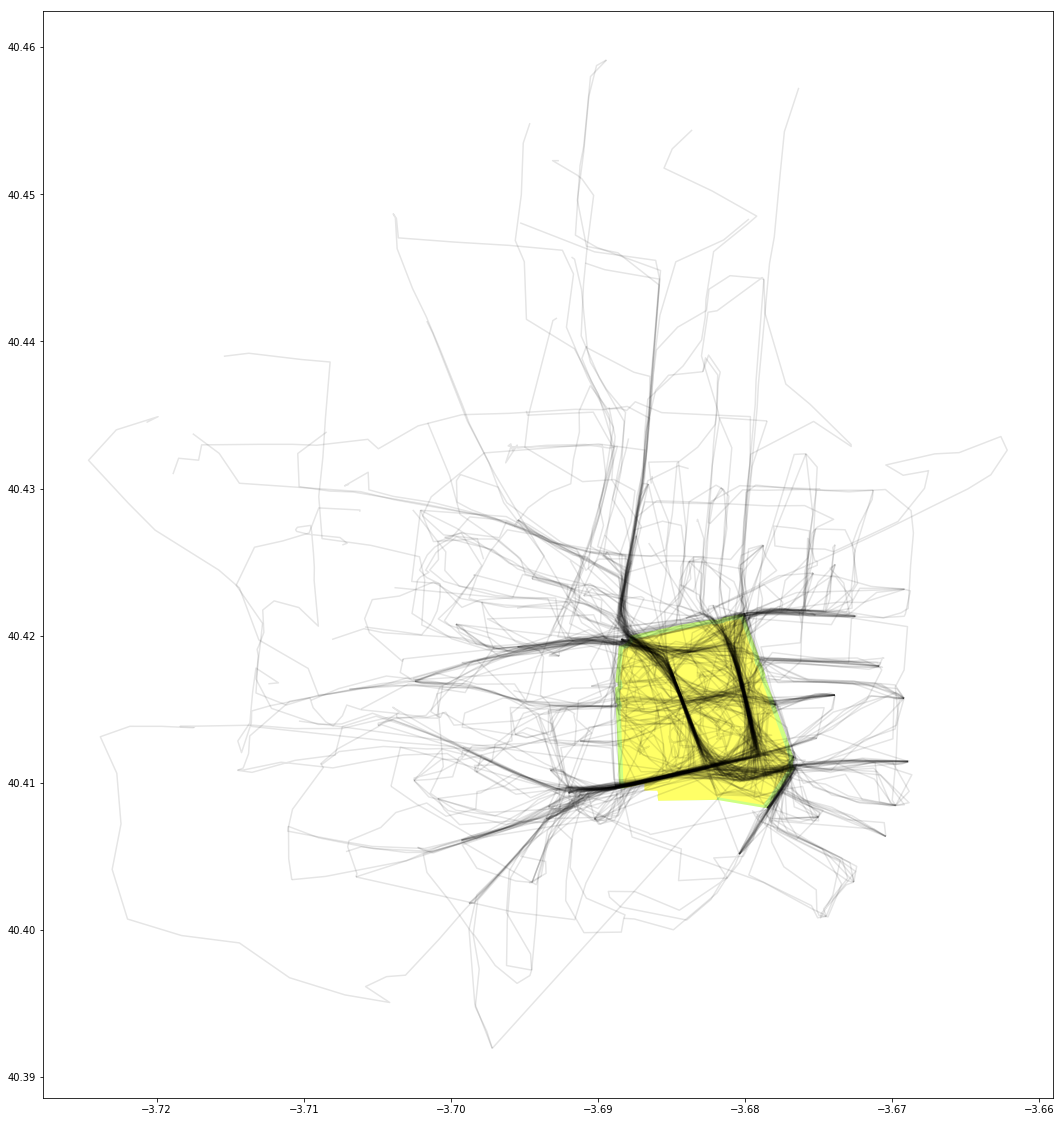

In [463]:
ax=raw_retiro.plot(figsize=[20,20], color='yellow', alpha=0.6)
#add_basemap(ax, zoom=10)
retiro(ax=ax, color='red', alpha=0.2)
pointsInRetiro.plot(ax=ax, color='black', alpha=0.1)
#pointsNotInRetiro.plot(ax=ax, color='red', alpha=0.1)

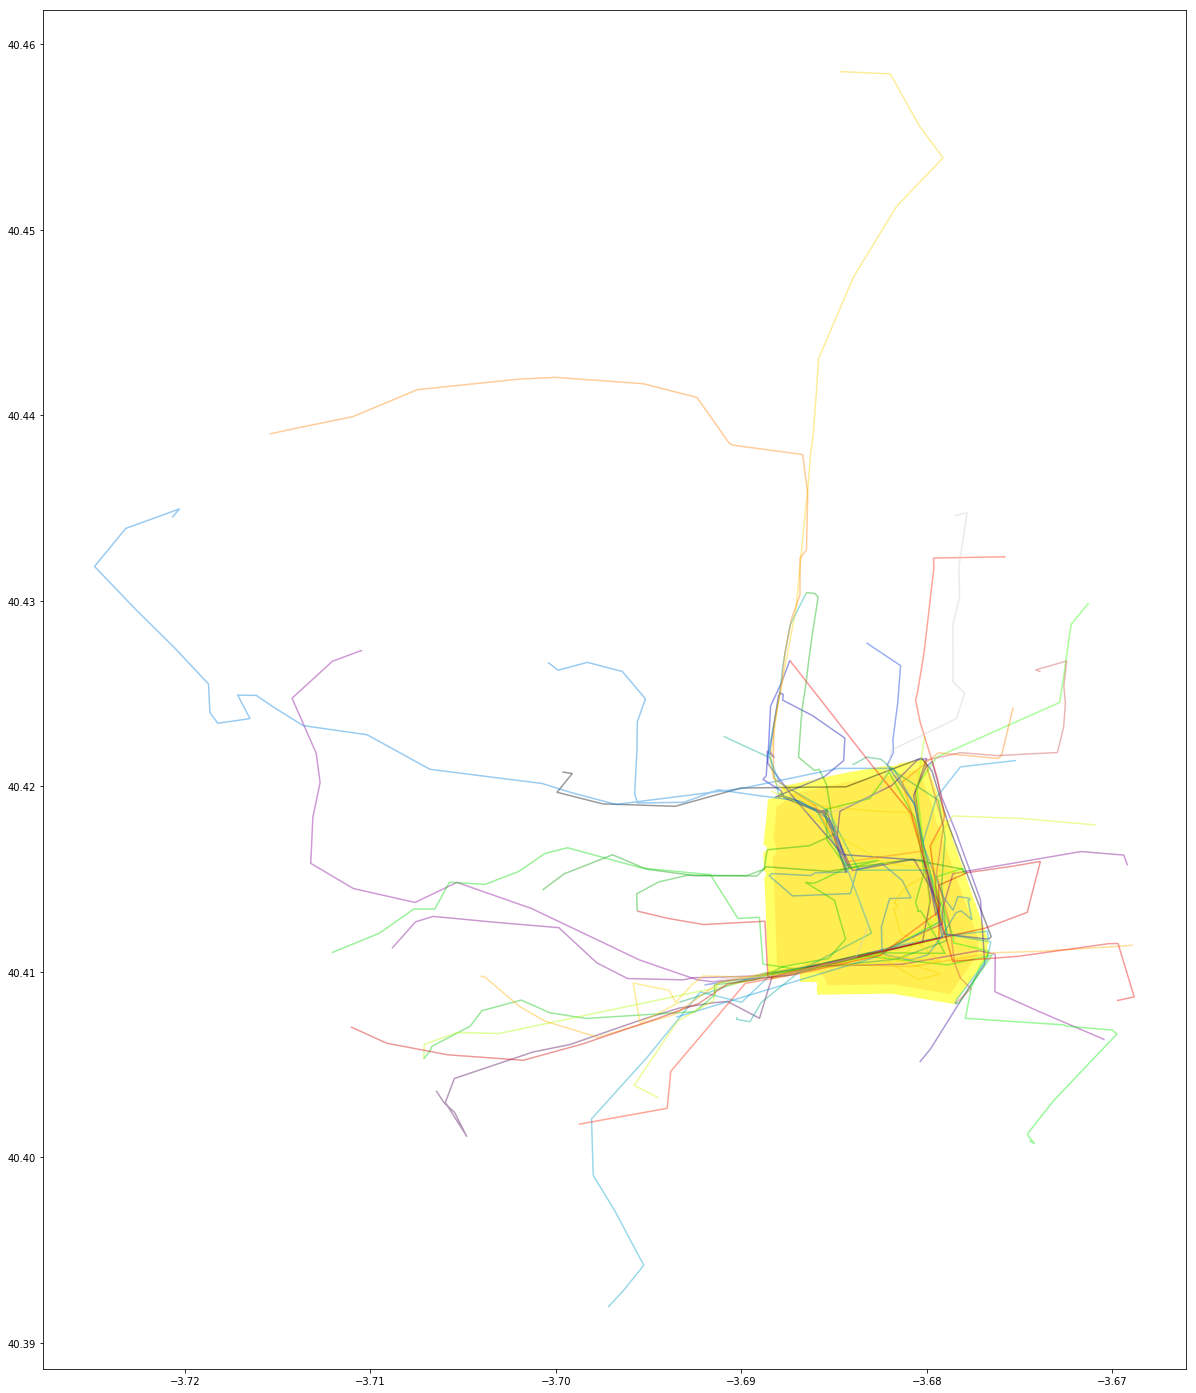

In [326]:
ax=raw_retiro.plot(figsize=[25,25], color='yellow', alpha=0.6)
#add_basemap(ax, zoom=10)
raw_retiro.buffer(-0.0005).plot(ax=ax, color='orange', alpha=0.2)
pointsInRetiro.plot(ax=ax, cmap='nipy_spectral', alpha=0.4)
#pointsNotInRetiro.plot(ax=ax, color='red', alpha=0.1)

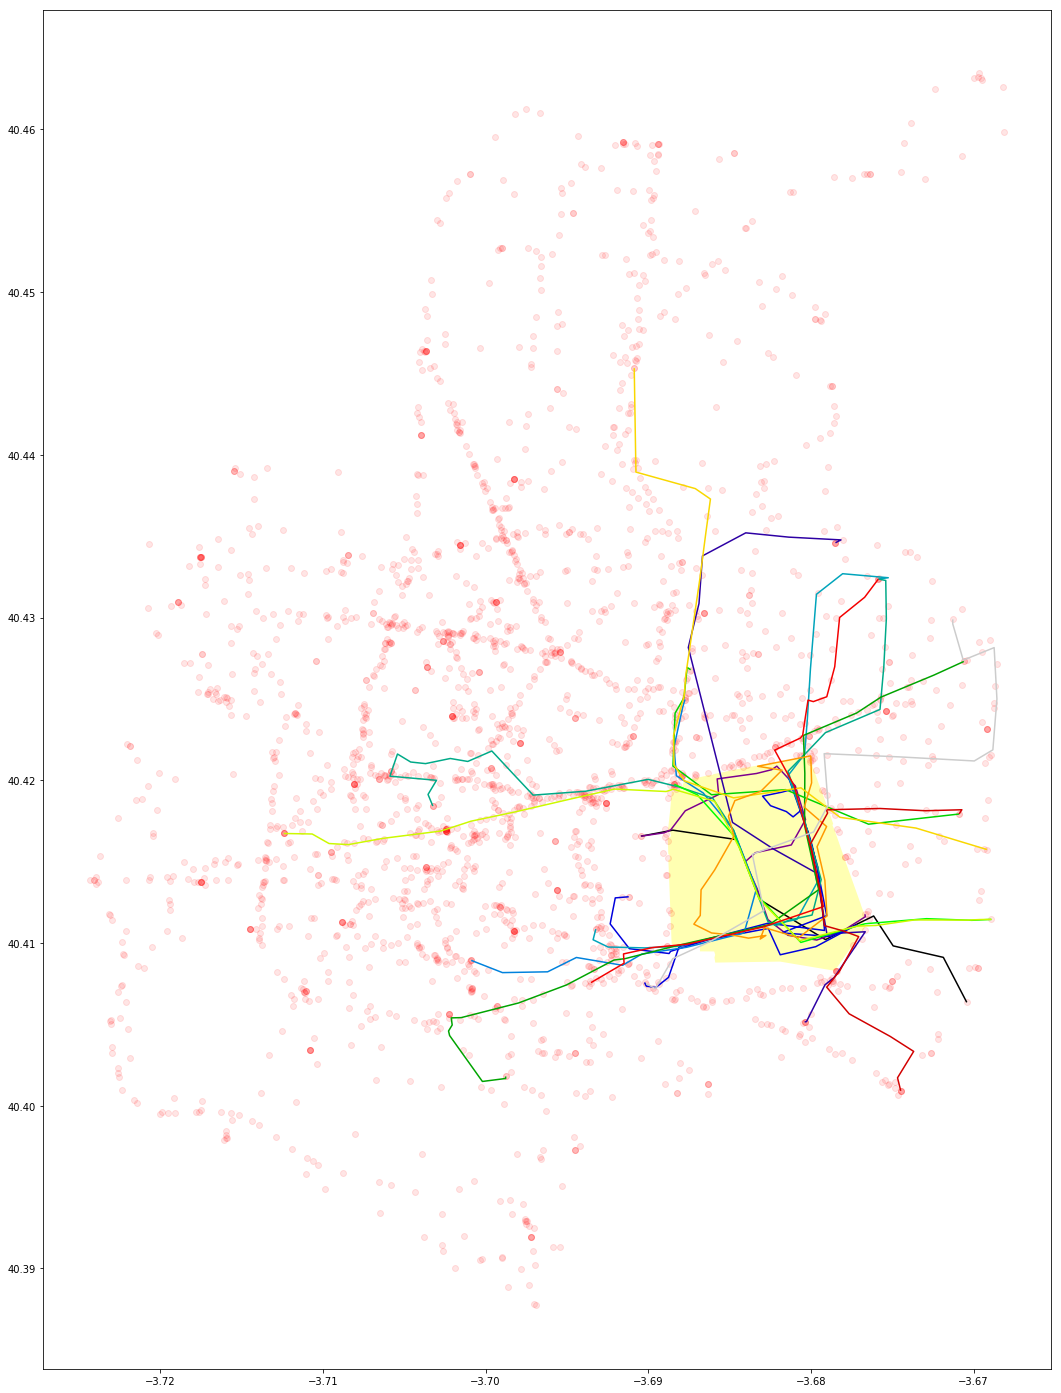

In [231]:
ax=retiro.plot(figsize=[25,25], color='yellow', alpha=0.3)
#add_basemap(ax, zoom=10)
pointsInRetiro.plot(ax=ax, cmap='nipy_spectral', alpha=1)
pointsNotInRetiro.plot(ax=ax, color='red', alpha=0.1)

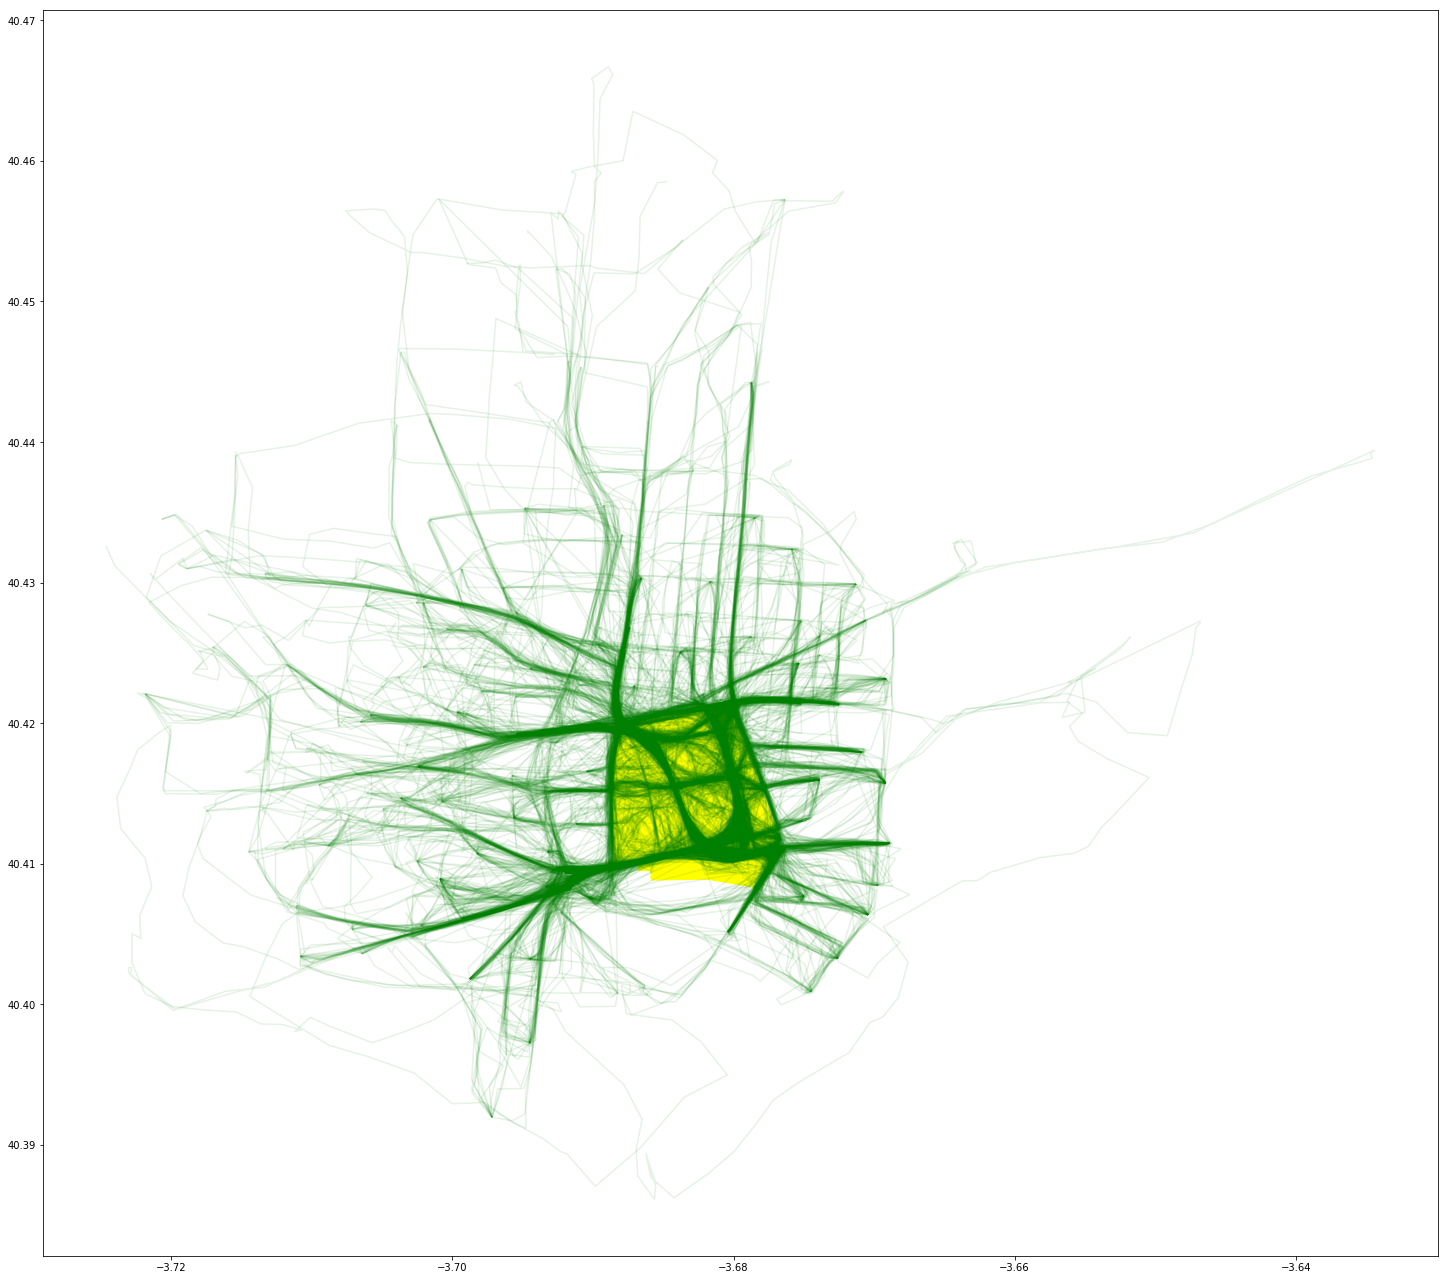

In [51]:
ax=retiro.plot(figsize=[25,25], color='yellow', alpha=1)
#add_basemap(ax, zoom=10)
pointsInRetiro.plot(ax=ax, color='green', alpha=0.1)
#pointsNotInRetiro.plot(ax=ax, color='red', alpha=0.1)

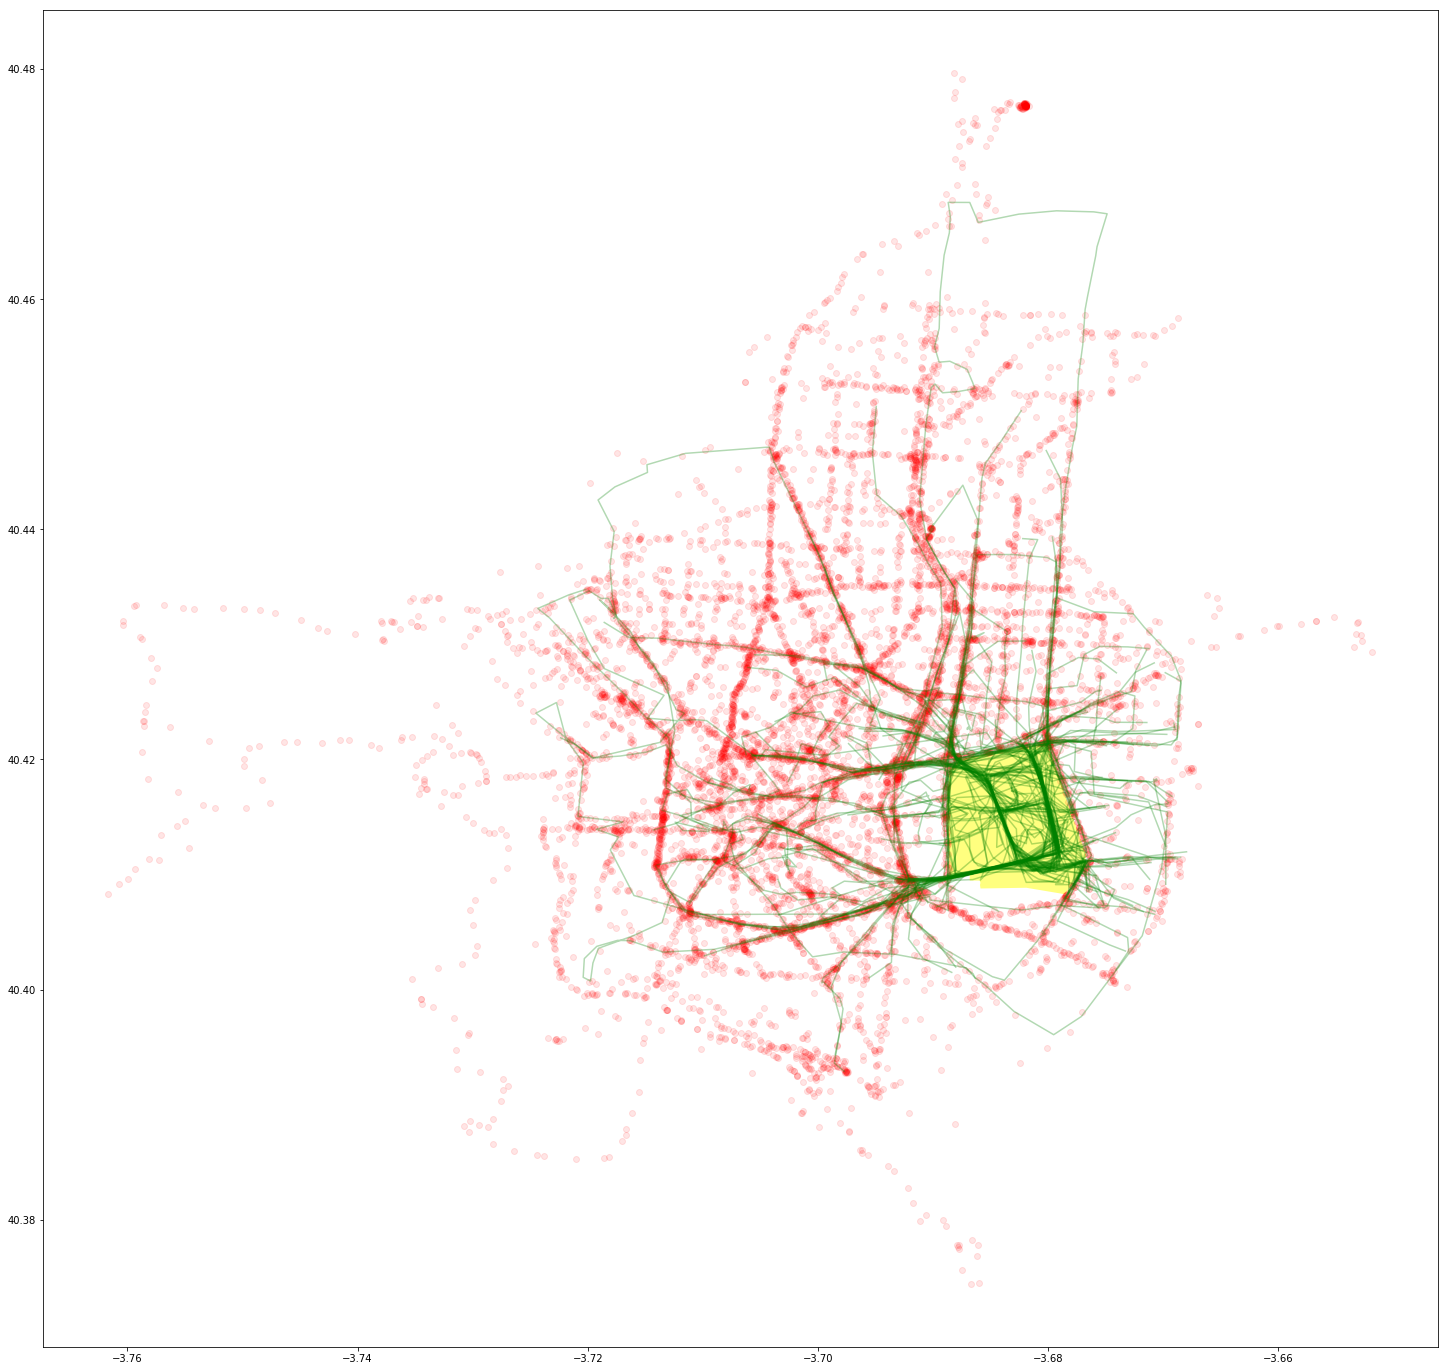

In [256]:
ax=retiro.plot(figsize=[25,25], color='yellow', alpha=0.5)
pointsInRetiro.plot(ax=ax, color='green', alpha=0.3)
pointsNotInRetiro.plot(ax=ax, color='red', alpha=0.1)

In [483]:
len(pointsInRetiro)

NameError: name 'pointsInRetiro' is not defined

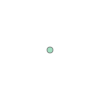

In [444]:
retiro.representative_point()

**<span style="color:red">Esta aquí la prueba con samples</span>**
***



In [363]:
rides.dtypes

_id                              object
ageRange                       category
full_track                       object
idplug_station                 category
idunplug_station               category
track                            object
travel_time                       int64
unplug_hourTime     datetime64[ns, CET]
user_day_code                    object
user_type                      category
zip_code                         object
dtype: object

In [364]:
#Vamos a aligerar el dataframe quitando la columna track pues tenemos el full_track disponible
rides = rides.drop(['track'], axis=1)

In [367]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224536 entries, 0 to 224535
Data columns (total 10 columns):
_id                 224536 non-null object
ageRange            224536 non-null category
full_track          224536 non-null object
idplug_station      224536 non-null category
idunplug_station    224536 non-null category
travel_time         224536 non-null int64
unplug_hourTime     224536 non-null datetime64[ns, CET]
user_day_code       224536 non-null object
user_type           224536 non-null category
zip_code            115959 non-null object
dtypes: category(4), datetime64[ns, CET](1), int64(1), object(4)
memory usage: 11.6+ MB
